# Score Aggregation Methods

We want to rank answers so that the best content floats to the top. The information we get is users' ratings of the answers. We must aggregate users' ratings in two ways: 

1. A single user will rate multiple aspects of a single answer (within-rating aggregation)
2. Multiple users rate a given answer (between-rating aggregation)

I'm focusing on the second kind of aggregation. Currently, SWARM just averages the scores.

## Rating honestly vs. strategically

We've noticed that as the deadline approaches, people are giving items more extreme scores (closer to 0 or 100) in order to move the average further, and get the item to the top or bottom of the pile. This is a sensible voting strategy. If I see that an item has a current score of 70 but believe it should have a score of 85, then I should give it a rating of 100 rather than 85, to move it closer to the correct score.

However, this voting strategy causes problems. It means our data on ratings is next to useless - we don't learn users' true opinion of the answer quality. It's also undemocratic. A user who gives an extreme rating has more leverage than a user who gives a rating close to the current average. 

Ideally, SWARM would use an aggregation method that elicits users' honest opinions of the answers, giving helpful feedback to the answer author and helpful data to the analytics team. Ideally we would rank items in a way that doesn't privilege one rater over another.

## Rank aggregation & impossibility theorems

To remove the incentive to gve extreme scores, the obvious solution is to use a rank aggregation method. Each user rates several answers, giving each a score out of 100 (after within-rating aggregation), but we don't need to use the exact numbers. Each rater's list of scores can be coarsened into a rank order of preferences. We can then use a standard method for aggregating ranks rather than real-valued scores.

Unfortunately, the [Gibbard-Satterthwaite Theorem](https://en.wikipedia.org/wiki/Gibbard%E2%80%93Satterthwaite_theorem) shows that rank aggregation methods cannot satisfy our desiderata: all "strategy-proof" methods for ranking more than two options must give all the power to a single rater. 

This might be particularly problematic for SWARM. Many voting systems are _robust_ to strategic voting, because the strategic voter needs lots of information about other voters' preferences. SWARM doesn't tell you exactly how other people are rating, but it lets you _change your own rating_ an arbitrary number of times. Users who wish to vote strategically could try different ratings until they achieve their desired outcome. 

[The space of possible rankings is large](https://en.wikipedia.org/wiki/Ordered_Bell_number), so if there are five or more answers, users cannot explore the space of rankings in a reasonable time. Even exploring a subset would take much more effort than just giving an extreme score. But it is an open question how often users would vote strategically if we aggregated answers like this.

The Gibbard-Satterthwaite Theorem tells us there is no perfect system, but we may be able to find a decent option - a system that produces something close to the ideal ranking in most cases, and which can't be manipulated without spending a lot of time and effort.

## Evaluating performance

The "ideal ranking" is undefined for any of our real examples, but we have some intuitions about which answers are best. I propose testing each rank aggregation method by looking at how it ranks the answers to **past questions** on SWARM Beta. A good method will accord pretty well with our intuitions; a bad one will not. However, this evaluation only gives us information about a small number of cases, and doesn't tell us about robustness to strategies other than "give extreme scores".

We can also evaluate performance using **synthetic data**. We randomly generate answers of varying quality, and sets of ratings that are realistically sparse and noisy. We apply the rank aggregation methods to this data, and see how close the overal ranking comes to the true rank order of the answers based on their quality. 

Because we can sample repeatedly, evaluation on synthetic data tells us about the average case performance of the ranking methods. However, it doesn't tell us about robustness to particular strategies (unless we build those strategies into the rating generation method, which would take a lot of work).

## Ranking Methods

I implement the following ranking methods:

1. Rank of average score (status quo in SWARM)
2. RdR's ranking method ("place everything with more than one rating above everthing with one rating. Within the two groups, rank by average score")
3. [Borda count](https://en.wikipedia.org/wiki/Borda_count) ("For each rater, for each answer, count how many other answers it _outranks_. Then for each answer, sum this count across all raters")
4. User Preference Ranking. This uses the exact score rather than just the rank, but it aggregates pairwise comparisons of items, among the set of users who have rated both items in the pair. It is more robust to sparse ranking. However it is still vulnerable to user manipultion using extreme scores. User Preference Ranking is described in Chapter 10 of _Who's #1?_ by Langville & Meyer.

All these methods start by creating a rater-by-answer matrix of ratings.

### Methods I am NOT implementing:

Evan Miller's [confidence interval-based method](http://www.evanmiller.org/how-not-to-sort-by-average-rating.html), the [Bayesian version](http://www.evanmiller.org/bayesian-average-ratings.html), the [star-rating version](http://www.evanmiller.org/ranking-items-with-star-ratings.html), and [Paul Masurel's variation](https://fulmicoton.com/posts/bayesian_rating/) take the _uncertainty_ around the average score into account. They rank by the lower bound of a confidence interval or credible interval around the average score, or smooth the average using a pseudocount. Unfortunately these methods are still centered on the mean, so they would still be vulnerable to the strategy of "give extreme scores". Users who give extremely low scores would have more power than before. Furthermore, we are unlikely to ever get enough ratings for the intervals to become narrow.

Minimum Violation Ranking (MVR), as described in Chapter 15 of _Who's #1?_ by Langville & Meyer, would take a set of users' rankings and produce an aggregate ranking that disagrees as little as possible with the input rankings. This method is optimal among all methods that use only rank data (as opposed to, for example, "average score" or "user preference rankings" which use the exact scores rather than just the ranks). It would do as well as or better than Borda count. However, the exact version of MVR requires solving an integer linear program  every time the scores are updated, which can take a long time. Langville & Meyer show you can speed it up by first solving a relaxed version of the problem. 

I chose not to implement MVR because (a) the implementation would be moderately complicated, (b) the runtime might be prohibitive, and (c) it's designed for aggregating complete rankings, not partial rankings. We would first turn the partial rankings into complete rankings by placing all unranked items _last_ in each user's ranking. So if I haven't had time to rate an answer, that is indistinguishable from me saying it is the worst answer. Given how sparse our data is, this is a very common case, so I think MVR would work poorly on our data.


## Data

We can't (currently) get the info we need from the SWARM API, because the API outputs ratings without identifying the user who made the rating. This makes it impossible to build the rater-by-answer matrix.

Currently I am pulling the data from a database dump. In order to make this work with SWARM, we would need to extend the API.

For evaluating the methods on synthetic data, I have developed a class that pulls the data from a CSV of a synthetic rater-by-answer matrix.


In [1]:
# need this because my python & anaconda installation is all kinds of messed up
import sys
sys.path.append("/Users/lizzie/anaconda/")
sys.path.append("/Users/lizzie/Library/Python/3.6/lib/python/site-packages")


## Define abstract score matrix class

This class implements the ranking methods. It's abstract because the _data_ for a score matrix could either be pulled from the SWARM DB, or generated synthetically, and I want to separate those cases. Those concrete classes are defined below.

In [13]:
import numpy as np
from abc import ABCMeta, abstractmethod

class AbstractScoreMatrix(object):
    """A rater-by-answer matrix of scores for answers to the question.
    
    Includes several ranking methods:
        (a) borda_count()
        (b) user_preferences()
        (c) rdr_rating()
        (d) mean_rating()
        (e) anca_rating()
    All of them return a 1D Numpy array with the *scores* of the answers.
    
    To implement these methods you need a user-by-answer matrix, where each cell contains a  
    single number representing that user's rating of that answer. Ratings are between 0 and 100. 
    
    If the user has not rated an item, I use -1 as the "missing data" value.
    
    This is an abstract class because the instantiation differs depending on where you get the  
    data from (a CSV file, a connection to the SWARM database + a question ID, etc.).
    """ 
    __metaclass__ = ABCMeta
    
    def mean_rating(self):
        """Returns the mean score of each item (i.e. the status quo of the platform)"""
        
        def nonmissing_mean(arr):
            if np.sum(arr >= 0) > 0:
                return np.mean(arr[np.where(arr >= 0)])
            else:
                return 0.0
        
        return np.apply_along_axis(nonmissing_mean, axis=0, arr=self.matrix)
    
    def rdr_rating(self, plugin="mean"):
        """Ranks every item that has at least two ratings above those with one rating or fewer.
        The 'plugin' is the rating scheme used to differentiate within these two groups - by  
        default,it is mean_rating().
        """
        if plugin=="borda":
            score_vec = self.borda_count()
        elif plugin=="user_prefs":
            score_vec = self.user_preferences()
        elif plugin=="mean":
            score_vec = self.mean_rating()
        else:
            raise ValueError('Did not recognize plugin rank method', plugin)
            
        rating_number = np.sum(self.matrix >= 0, axis=0)
        
        # find the max score among items with one or zero ratings. Add that number to all 
        # items with more than one rating.
        if np.sum(rating_number <= 1) > 0:
            addon = np.max(score_vec[np.where(rating_number <= 1)])
            score_vec[np.where(rating_number > 1)] += addon
        
        return score_vec
    
    def borda_count(self, count_zeroes=False):
        """Returns a 1D Numpy array with the Borda count of all answers. 
        
        I modify Borda count slightly by giving a 1-point bonus to items that have a rating 
        (when count_zeroes=False).
        
        Setting count_zeroes=True means that all rated items are considered to rank higher
        than unrated items. For example, if a rater only rated one out of ten answers, 
        that answer would receive nine points (as opposed to one).
        """
        
        def borda(arr, count_zeroes=False):
            res = []
            for v in arr:
                if count_zeroes:
                    res.append(sum(arr < v))
                else:
                    res.append(sum((arr < v) & (arr >= 0)))
            
            # add one to each item that has a score
            return np.array(res) if count_zeroes else np.array(res) + (arr > -1)

        barr = np.apply_along_axis(borda, axis=1, arr=self.matrix, count_zeroes=count_zeroes)
        foo = np.sum(barr, axis=0)
        
        return foo
    
    def get_missing_subset(self):
        """Return a dictionary of the indices of answers that have been scored and answers that  
        haven't (and raters that have provided scores, and raters that havent).
        Used in a preprocessing step in user_preferences(), to get a subset of the score matrix 
        where unrated items have been dropped (and useless raters have been dropped).
        Retaining a list of indices of the dropped items means we can still create an overall  
        ordering of all items (rated and unrated).
        """
        
        subset = {'answers':{'data':np.where(np.logical_not(np.all(self.matrix == -1, 
                                                                   axis=0)))[0], \
                             'missing':np.where(np.all(self.matrix == -1, axis=0))[0]}, \
                  'raters':{'data':np.where(np.logical_not(np.all(self.matrix == -1, 
                                                                  axis=1)))[0], \
                            'missing':np.where(np.all(self.matrix == -1, axis=1))[0]}}
        return subset
    
    def get_subset_matrix(self):
        """Returns a subset of the score matrix that drops all rows and columns that contain 
        no rankings
        """
        
        return self.matrix[self.subset['raters']['data'][:,None], 
                           self.subset['answers']['data']]
    
    def user_preferences(self):
        """calculates rank according to user preference rankings, as detailed in chapter 10 of
        'Who's #1?' by Langville and Meyer
        """
        
        m = len(self.subset["answers"]["data"])
        
        if m < 1:
            raise ValueError("No answers have been rated!")
        
        if len(self.subset["raters"]["data"]) < 1:
            raise ValueError("No users have rated answers!")
            
        if m==1:
            raise ValueError("Only one answer has been rated!")
            
        score_mat = self.get_subset_matrix()
        kmat = np.zeros((m,m))
        
        for i in range(m):
            for j in range(i+1, m):
                foo = np.all((score_mat[:,[i,j]] > 0), axis=1)
                if np.any(foo):
                    sij = np.sum(score_mat[np.where(foo), i]) / sum(foo)
                    sji = np.sum(score_mat[np.where(foo), j]) / sum(foo)
                    kmat[i,j] = sij - sji
                    kmat[j,i] = sji - sij
        
        rvec = np.sum(kmat,axis=1)/m
        
        # normalize, so everything that has received a rating is at least one point higher 
        # than unrated items
        rvec = rvec - np.min(rvec - 1)
        
        # Insert the rated items into a vector containing scores for all items
        all_rvec = np.zeros((len(self.answer_ids)))
        for i in range(len(rvec)):
            all_rvec[self.subset["answers"]["data"][i]] = rvec[i]
            
        return all_rvec

    def anca_rating(self):
        """modified version of user preference rankings, suggested by Anca:
        just use the win-loss ratio, not the exact point differences.
        """
        
        m = len(self.subset["answers"]["data"])
        
        if m < 1:
            raise ValueError("No answers have been rated!")
        
        if len(self.subset["raters"]["data"]) < 1:
            raise ValueError("No users have rated answers!")
            
        if m==1:
            raise ValueError("Only one answer has been rated!")
            
        score_mat = self.get_subset_matrix()
        kmat = np.zeros((m,m))
        
        for i in range(m):
            for j in range(i+1, m):
                foo = np.all((score_mat[:,[i,j]] > 0), axis=1)
                if np.any(foo):
                    sij = np.sum(score_mat[np.where(foo), i] > score_mat[np.where(foo), j]) / sum(foo)
                    sji = np.sum(score_mat[np.where(foo), j] > score_mat[np.where(foo), i]) / sum(foo)
                    kmat[i,j] = sij - sji
                    kmat[j,i] = sji - sij
        
        rvec = np.sum(kmat,axis=1)/m
        
        # normalize, so everything that has received a rating is at least one point higher 
        # than unrated items
        rvec = rvec - np.min(rvec - 1)
        
        # Insert the rated items into a vector containing scores for all items
        all_rvec = np.zeros((len(self.answer_ids)))
        for i in range(len(rvec)):
            all_rvec[self.subset["answers"]["data"][i]] = rvec[i]
            
        return all_rvec


## Define synthetic score matrix class


In [14]:
import scipy.stats as stats
from scipy.special import expit, logit

class ScoreMatrixSynthetic(AbstractScoreMatrix):
    """Generates a rater-by-answer matrix of scores for answers to the question.
    Note that -1 indicates missing data.
    """ 
    
    def __init__(self, n=30, rnoise=0.5, qnoise=0.05, punrated=0.2, 
                 pslacker=.1, plurker=.2, enoise=.5, toprated=True, diag=False):
        self.matrix = self.get_score_matrix(n, rnoise, qnoise, punrated, pslacker, plurker, toprated, diag)
        self.answer_ids = range(self.matrix.shape[1])
        self.rater_ids = range(self.matrix.shape[0])
        self.subset = self.get_missing_subset()
        
    def get_score_matrix(self, n=30, rnoise=0.5, qnoise=0.05, punrated=0.2, 
                         pslacker=.1, plurker=.2, enoise=.5, toprated=True, diag=False):
        """produces user-by-answer score matrix (as a 2D Numpy array)"""
        
        # draw from a truncated Gaussian distribution.
        # Note that this is a rejection sampling method, will be VERY SLOW if
        # sigma is large relative to the distance between lower and upper.
        def trunc_gauss(mu=0.5, sigma=1, lower=0, upper=1):
            if mu <= lower or mu >= upper:
                raise ValueError('mu outside bounds', mu, lower, upper)
            
            y = -1
            while y <= lower or y >= upper:
                y = np.random.normal(loc=mu,scale=sigma)
            return y
        
        trunc_gauss_vec = np.vectorize(trunc_gauss)
        
        # draw ability uniformly between 0 and 1
        ability = np.random.random(n)
        # draw each rater's "easiness" value from a gaussian
        easiness = np.random.normal(loc=0, scale=enoise, size=n)
        
        # add (truncated) Gaussian noise to get quality of answers
        quality = trunc_gauss_vec(ability, sigma=qnoise)
        
        # set up ratings matrix
        A = np.empty((n,n), dtype=float)
        for i in range(n):
            # draw all ratings
            ratings_i = trunc_gauss_vec(quality, sigma = (1-ability[i])*rnoise)
            # add easiness bias for this rater
            ratings_i = expit(logit(ratings_i) + easiness[i])
            A[i,:] = ratings_i
            
            # unrated: draw number of unrated answers
            ki = np.random.binomial(n, punrated)
            if toprated:
                # see that rater's top-rated answers
                Aki = np.argsort(A[i,:])[range(ki)]
            else: 
                # see ratings for a random set of answers
                Aki = np.random.choice(n, ki, replace=False)
            # set unrated elements to -1 (missing)
            if len(Aki) > 0:
                A[i, Aki] = -1

        # can't rate your own answers
        if not diag:
            np.fill_diagonal(A,-1)

        # "slackers" are people who don't rate answers
        # pick slackers with probability p, remove their rows from the matrix
        kslack = np.random.binomial(n, pslacker)
        slack = np.random.choice(n, kslack, replace=False)
        A = np.delete(A, slack, 0)

        # "lurkers" are people who don't write answers
        # pick lurkers with probability p, remove their columns from the matrix
        klurk = np.random.binomial(n, plurker)
        lurk = np.random.choice(n, klurk, replace=False)
        A = np.delete(A, lurk, 1)
        self.quality = np.delete(quality, lurk)
        
        return A
    
    
    def kendalltau(self):
        borda_tau, borda_p_value = stats.kendalltau(self.quality, self.borda_count())
        mean_tau, mean_p_value = stats.kendalltau(self.quality, self.mean_rating())
        rdr_tau, rdr_p_value = stats.kendalltau(self.quality, self.rdr_rating())
        prefs_tau, prefs_p_value = stats.kendalltau(self.quality, self.user_preferences())
        anca_tau, anca_p_value = stats.kendalltau(self.quality, self.anca_rating())
        
        tau_dict = {"taus":{"borda":borda_tau, "mean":mean_tau, 
                            "rdr":rdr_tau, "prefs":prefs_tau, "anca":anca_tau},
                    "p_values":{"borda":borda_p_value, "mean":mean_p_value, 
                                "rdr":rdr_p_value, "prefs":prefs_p_value, 
                                "anca":anca_p_value}}
        return tau_dict
    
    
    def spearmanrho(self):
        borda_rho, borda_p_value = stats.spearmanr(self.quality, self.borda_count())
        mean_rho, mean_p_value = stats.spearmanr(self.quality, self.mean_rating())
        rdr_rho, rdr_p_value = stats.spearmanr(self.quality, self.rdr_rating())
        prefs_rho, prefs_p_value = stats.spearmanr(self.quality, self.user_preferences())
        anca_rho, anca_p_value = stats.spearmanr(self.quality, self.anca_rating())
        
        if np.isnan(mean_rho):
            print(self.quality)
            print(self.mean_rating())
            print(self.matrix)
            print(stats.spearmanr(self.quality, self.mean_rating()))
        
        rho_dict = {"rhos":{"borda":borda_rho, "mean":mean_rho, 
                            "rdr":rdr_rho, "prefs":prefs_rho, "anca":anca_rho},
                    "p_values":{"borda":borda_p_value, "mean":mean_p_value, 
                                "rdr":rdr_p_value, "prefs":prefs_p_value,
                                "anca":anca_p_value}}
        return rho_dict
    
    
    def topn(self, n):
        """Returns a dict with the proportion of the top n results correctly identified by 
        each ranking method. E.g. if n=3, and in the true quality vector, answers 1, 6 and  
        8 are the top 3, and Borda count identifies answers 1, 5 and 8 as its top 3, then   
        Borda count gets a score of 0.67."""
        
        list_limit = len(self.quality) - 1
        top_n = np.argsort(self.quality)[list_limit-n:list_limit]

        borda_top = np.argsort(self.borda_count())[list_limit-n:list_limit]
        mean_top = np.argsort(self.mean_rating())[list_limit-n:list_limit]
        rdr_top = np.argsort(self.rdr_rating())[list_limit-n:list_limit]
        prefs_top = np.argsort(self.user_preferences())[list_limit-n:list_limit]
        anca_top = np.argsort(self.anca_rating())[list_limit-n:list_limit]
        
        top_dict = {"borda_top" : len(set(top_n).intersection(borda_top)) / float(n),
                     "mean_top" : len(set(top_n).intersection(mean_top)) / float(n),
                     "rdr_top" : len(set(top_n).intersection(rdr_top)) / float(n),
                     "prefs_top" : len(set(top_n).intersection(prefs_top)) / float(n),
                     "anca_top" : len(set(top_n).intersection(anca_top)) / float(n)}
        return top_dict
    
    
    def get_missing_subset(self):
        """Return a dictionary of the indices of answers that have been scored and answers that  
        haven't (and raters that have provided scores, and raters that havent).
        Used in a preprocessing step in user_preferences(), to get a subset of the score matrix 
        where unrated items have been dropped (and useless raters have been dropped).
        Retaining a list of indices of the dropped items means we can still create an overall  
        ordering of all items (rated and unrated).
        """
        
        subset = {'answers':{'data':np.where(np.logical_not(np.all(self.matrix == -1, 
                                                                   axis=0)))[0], \
                             'missing':np.where(np.all(self.matrix == -1, axis=0))[0]}, \
                  'raters':{'data':np.where(np.logical_not(np.all(self.matrix == -1, 
                                                                  axis=1)))[0], \
                            'missing':np.where(np.all(self.matrix == -1, axis=1))[0]}}
        return subset

    
    def display(self, rank_method):
        
        if rank_method=="borda":
            score_vec = self.borda_count()
        elif rank_method=="user_prefs":
            score_vec = self.user_preferences()
        elif rank_method=="mean":
            score_vec = self.mean_rating()
        elif rank_method=="rdr":
            score_vec = self.rdr_rating()
        elif rank_method=="anca":
            score_vec = self.anca_rating()
        else:
            raise ValueError('Did not recognize rank method', rank_method)
        
        ordered_indices = np.flip(np.argsort(score_vec), axis=0)
        i = 0
        round_vec = np.around((score_vec / np.max(score_vec))*100, decimals=1)
        
        return round_vec

    

## Simulation study

I start by generating syntethic data. I vary the following parameters:

* ```rnoise```, a scaling factor that increases the amount of noise in the ratings
* ```punrated```, the probability that a given rating will be hidden
* ```pslacker```, the probability that a user will fail to submit any ratings 
* ```plurker```, the probability that a user will fail to submit an answer
* ```toprated```: if this is True, the user will rate the answers they consider best, and fail to rate the answers they consider worse. 
    * Note: There is no set number of ratings the user completes. The number of ratings for each user, *k*, is drawn from a binomial with probability = ```1 - punrated```. Whether those *k* ratings are then distributed uniformly, or the user rates their *k* top answers, depends on ```toprated```.
* ```enoise```: Each user has an "easiness" bias parameter that is drawn from a Gaussian, reflecting that some users are harsher raters and some are easier. ```enoise``` is the standard deviation of that Gaussian.

In [22]:
import pandas as pd

In [38]:
runs = 30
rnoise = [.4, .6]
punrated = [.3, .7]
pslacker = [.3, .6]
plurker = [.5]
toprated = [True, False]
enoise = [0.1, 0.5]

numrows = runs * len(rnoise) * len(punrated) * len(pslacker) * len(plurker) * len(enoise) * len(toprated)

dfe = pd.DataFrame(index=np.arange(0, numrows), 
                  columns=('mean_rho', 'rdr_rho', 'borda_rho', 'prefs_rho', 'anca_rho',
                           'mean_top1', 'rdr_top1', 'borda_top1', 'prefs_top1', 'anca_top1',
                           'mean_top2', 'rdr_top2', 'borda_top2', 'prefs_top2', 'anca_top2',
                           'mean_top3', 'rdr_top3', 'borda_top3', 'prefs_top3', 'anca_top3',
                           'rnoise', 'punrated', 'pslacker', 'plurker', 'enoise',
                           'toprated', 'numraters', 'numanswers', 'numratings', 
                           'propnratings') )
j = 0

for i in range(runs):
    for rn in rnoise:
        for pu in punrated:
            for ps in pslacker:
                for pl in plurker:
                    for en in enoise:
                        for topr in toprated:
                            test_sm_class = ScoreMatrixSynthetic(n=30, rnoise=rn, qnoise=0.05, 
                                                                 punrated=pu, pslacker=ps, plurker=pl, 
                                                                 enoise=en, toprated=topr, diag=False)
                            rhos = test_sm_class.spearmanrho()
                            top1 = test_sm_class.topn(1)
                            top2 = test_sm_class.topn(2)
                            top3 = test_sm_class.topn(3)
                            numraters, numanswers = test_sm_class.matrix.shape
                            numratings = np.sum(test_sm_class.matrix != -1)
                            propratings = numratings / (numraters * numanswers - min(numratings, numanswers))

                            result_j = [rhos["rhos"]["mean"], rhos["rhos"]["rdr"], 
                                         rhos["rhos"]["borda"], rhos["rhos"]["prefs"], 
                                         rhos["rhos"]["anca"], 
                                         top1["mean_top"], top1["rdr_top"], 
                                         top1["borda_top"], top1["prefs_top"],
                                         top1["anca_top"],
                                         top2["mean_top"], top2["rdr_top"], 
                                         top2["borda_top"], top2["prefs_top"],
                                         top2["anca_top"],
                                         top3["mean_top"], top3["rdr_top"], 
                                         top3["borda_top"], top3["prefs_top"],
                                         top3["anca_top"],
                                         rn, pu, ps, pl, en, topr, numraters, numanswers, 
                                         numratings, propratings]
                            dfe.loc[j] = result_j

                            j +=1
                            print(j)
                        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [39]:
dfe.to_csv("sim_3.csv")


In [40]:
df = pd.read_csv("sim_3.csv", index_col=0)

## Plan for analysis:

* In worst case (high noise, few ratings, etc.), and in best case,
    * Which methods get the top answer right?
    * Which methods have highest Spearman's rho?
* What effect does setting topn=True have?
* What effect does the easiness bias have?

## Plot results

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

### Mean Spearman's Rho

Grouped by the two probabilities controlling how small (```pslacker```) and sparse (```punrated```) the ratings matrix is.

RdR's method performs slightly worse in sparsest condition, though still within error bars. Otherwise, the performance of Mean, RdR, Prefs and Anca rating are indistinguishable. 

Borda count underperforms in all conditions.

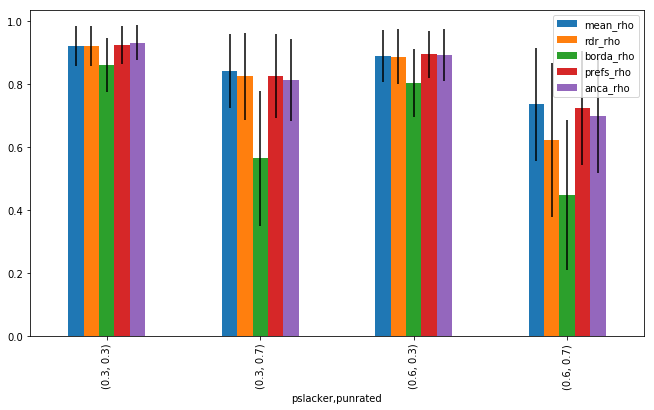

In [51]:
gp3 = df.groupby(['pslacker','punrated' ])[["mean_rho","rdr_rho","borda_rho","prefs_rho","anca_rho" ]]
means = gp3.mean()
errors = gp3.std()
fig, ax = plt.subplots(figsize=(11,6))
means.plot.bar(yerr=errors, ax=ax)

### Size of easiness bias has little effect

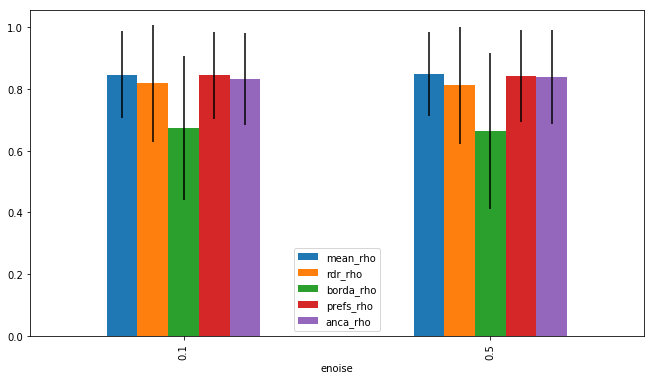

In [62]:
gp3 = df.groupby(['enoise'])[["mean_rho","rdr_rho","borda_rho","prefs_rho","anca_rho" ]]
means = gp3.mean()
errors = gp3.std()
fig, ax = plt.subplots(figsize=(11,6))
means.plot.bar(yerr=errors, ax=ax)

### How often the top-rated item was the best item

grouped by whether people were rating the top answers or a random selection

Again, Borda count underperforms.

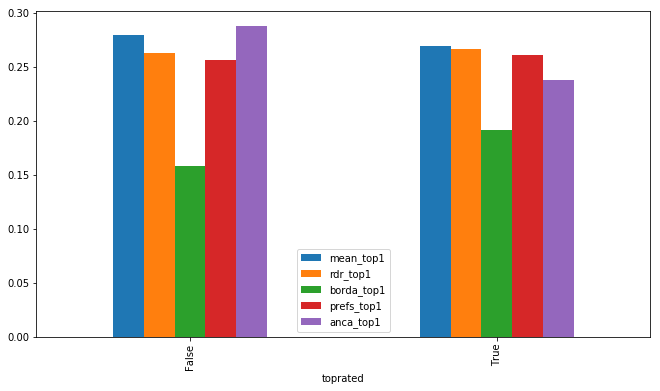

In [53]:
gp3 = df.groupby(['toprated' ])[[ "mean_top1","rdr_top1","borda_top1","prefs_top1","anca_top1" ]]
means = gp3.mean()
errors = gp3.std()
fig, ax = plt.subplots(figsize=(11,6))
means.plot.bar(ax=ax)

### Now, grouped by the sparsity parameters

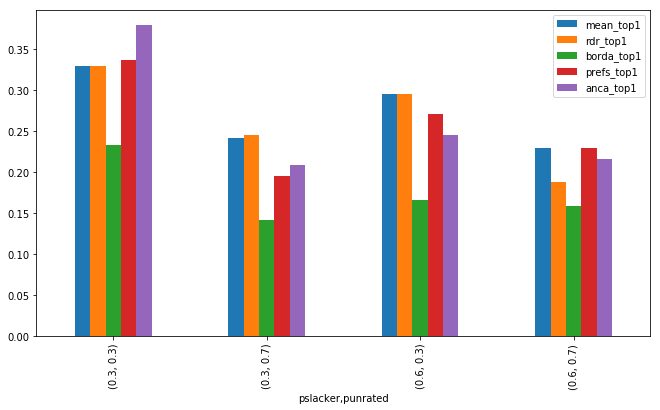

In [54]:
gp3 = df.groupby(['pslacker','punrated' ])[[ "mean_top1","rdr_top1","borda_top1","prefs_top1","anca_top1" ]]
means = gp3.mean()
errors = gp3.std()
fig, ax = plt.subplots(figsize=(11,6))
means.plot.bar(ax=ax)

### Random exploration: number of ratings vs. speaman's rho

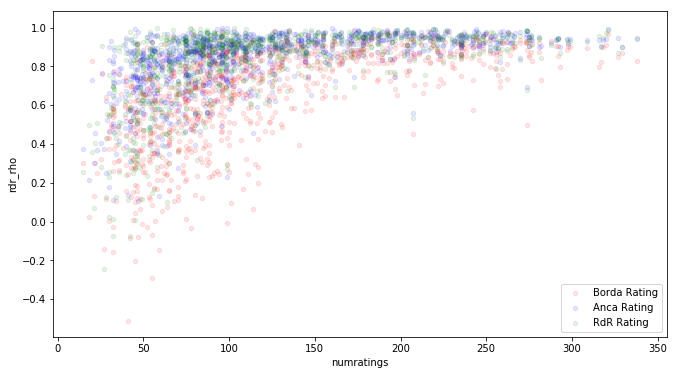

In [61]:
ax = df.plot.scatter(x='numratings', y='borda_rho', color='red', alpha=0.1, label='Borda Rating', figsize=(11,6));

df.plot.scatter(x='numratings', y='anca_rho', color='blue', alpha=0.1, label='Anca Rating', ax=ax);

df.plot.scatter(x='numratings', y='rdr_rho', color='green', alpha=0.1, label='RdR Rating', ax=ax);

# Appendix: notes to self

## User preference ranking

In Chapter 10 of _Who's #1?_, Langville & Meyer describe a ranking method for _products_ (analogous to answers on SWARM) that have been rated by users according to a star rating scale - that is, given an integer score between 1 and 5. 

### Formulation:

If there are $m$ users and $n$ products, the ratings can be turned into an $m$-by-$n$ user-by-product matrix. 

$$\mathbf{A} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$$

For example:

|  | $p_1$ | $p_2$ | $p_3$ | $p_4$ | 
|---|---|---|---|---|
| $u_1$ |  3 |   |   |  5 | 
| $u_2$ |   | 2  | 2  |  4 | 
| $u_3$ |  3 |   |  3 |   | 
| $u_4$ |  1 | 4  |   |  5 | 
| $u_5$ |   |  5 |  2 |   | 
| $u_6$ |   |   |  1 |  3 | | 

Note that the ratings are _sparse_ - users do not have to rate all products.

Langville & Meyer begin (page 118) by defining an $n$-b-$n$ skew-symmetric matrix, $\mathbf{K}$, which holds the pairwise differences between the the products:

$$\mathbf{K} =
 \begin{pmatrix}
  0 & k_{1,2} & \cdots & k_{1,n} \\
  k_{2,1} & 0 & \cdots & k_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  k_{n,1} & k_{n,2} & \cdots & 0
 \end{pmatrix}$$

Then (page 128) they define the $k_{i,j}$ terms for this application:

$$k_{i,j} = -k_{j,i} = \begin{cases}
\frac{1}{n_{i,j}} \sum_{u \in U_i \cap U_j} a_{u,i} - a_{u,j} & \mbox{ if } n_{i,j} \neq 0\\
0 & \mbox{ if } n_{i,j} = 0
\end{cases}$$

where $U_i$ is the set of users who have rated product $p_i$, so $\{u: u \in U_i \cap U_j\}$ is the set of users who have rated both products $p_i$ and $p_j$, and $n_{i,j}$ is the number of users in $\{u: u \in U_i \cap U_j\}$.

Once we have $\mathbf{K}$, finding the overall rating vector $\mathbf{r}$ is simple. Simply take the row means - that is,

$$\mathbf{r} = \frac{\mathbf{Ke}}{n}$$

where $\mathbf{e}$ is a vector of ones.

### Properties

 - User preference ranking is based on pairwise comparisons between items.
 - It automatically takes into account that some people are "easy graders" - the absolute values of their ratings doesn't matter, only the _difference_ in the scores between pairs of items they have rated.
 - Users must rate at least two items for their ratings to affect the ranking.
 - Users influence pairwise comparisons whenever they rate both items in the pair. Call the "power" of a user the number of distinct pairs of items they have rated. If the user has rated $k$ items, their power is $\frac{k^2 - k}{2}$.
 - User preferences are vulnerable to users voting strategically like so: give an extremely high score to _one_ item, and extremely low scores to several other items. 

## Why does the "get_missing_subset" method exist?

- User preference ranking can give things a negative score - the mean score is zero! And unrated items have a score of zero by default.
- So I need some way to screen out the answers that haven't been rated AT ALL.
- but that means keeping track of the indices of answers in the ranked and unranked subsets, keeping track of the number of ranked answers (for iterating), etc.
- And maybe I should make it general - so it applies to Borda count as well.